## Image segmentation with CamVid

In this notebook, we will try to perform Image Segmentation.

### What is Image Segmentation?
Image segmentation is the technique where an image is divided or segmented to various labels. Each pixel in the image belongs to a particular label. For e.g. in this dataset, we will have multiple labels such as road, animal, bicycle, car and many more. This dataset has 32 labels.

Generally there are 2 types of segmentation.
- Semantic Segmentation: Separation of classes such as road, person, etc.
- Instance Segmentation: Each class is separated into more classes. For instance each person in a segment of people.  
<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2019/03/Screenshot-from-2019-03-28-12-08-09.png" alt="segmentation" />

### Import some functions

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.basics import *

### Importing the dataset

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

### Let's have a look at the images and the labels

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0001TP_006900.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f01860.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_01800.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f04380_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_006930_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f02760_P.png')]

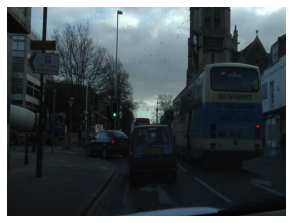

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

x.stem and x.suffix only work on Path objects.
They remove the words before and after the dot.

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

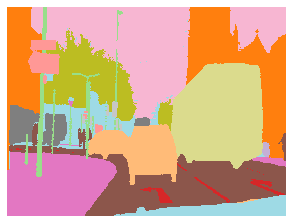

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
mask.shape

torch.Size([1, 720, 960])

In [11]:
src_size = np.array(mask.shape[1:])                 
print(src_size)
mask.data

[720 960]


tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
         [ 4,  4,  4,  ..., 21, 21, 21],
         [ 4,  4,  4,  ..., 21, 21, 21],
         ...,
         [19, 19, 19,  ..., 30, 30, 30],
         [19, 19, 19,  ..., 30, 30, 30],
         [19, 19, 19,  ..., 30, 30, 30]]])

In [12]:
# Let's have a look at all the labels
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [13]:
size = src_size//2              # Convert the image and mask size to half

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11438MB of GPU RAM free


In [14]:
size                      # Size of image data and masks will be half of original

array([360, 480])

You need minimum of 8+ GB of GPU RAM to use batch size of 8.

### Let's create the DataBunch used to input the images and labels to the model

In [19]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [20]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  return _solve_func(B,A)[0][:,0]


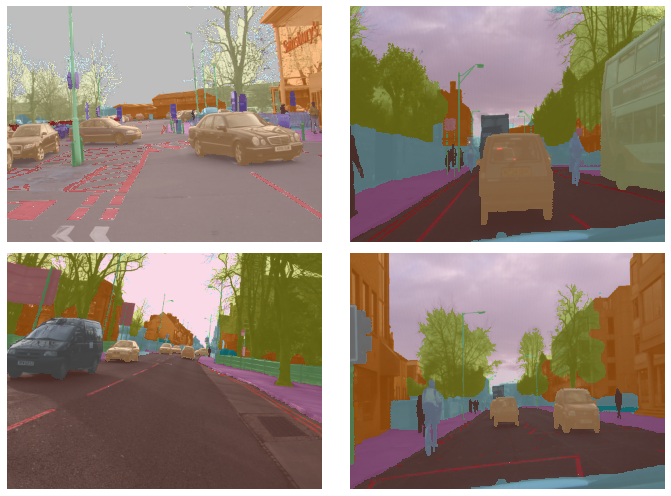

In [21]:
data.show_batch(2, figsize=(10,7))

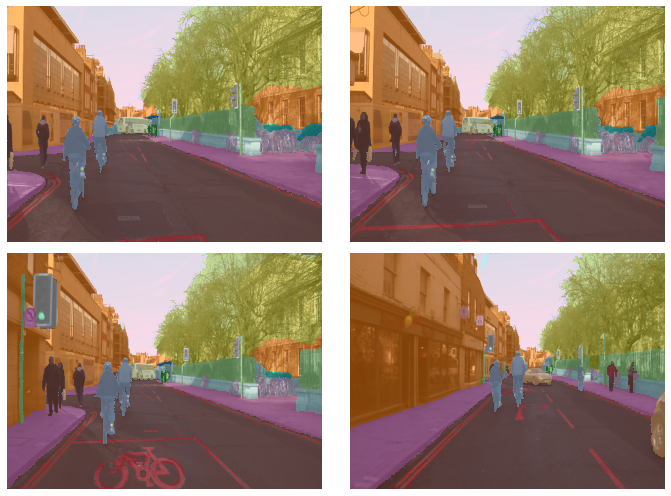

In [22]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

### Image Segmentation with UNet Model

UNet is the most popular model used for Image Segmentation. It was introduced for Biomedical Image Segmentation. The architecture had two main parts that were encoder and decoder. 
- The encoder is all about the covenant layers followed by pooling operation. It is used to extract the factors in the image. 
- The decoder uses transposed convolution to permit localization.

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" alt='unet' />

In [23]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [24]:
metrics=acc_camvid
# metrics=accuracy      # We can also use accuracy

In [25]:
wd=1e-2     # Weight decay

In [26]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


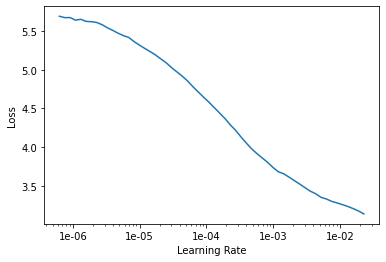

In [27]:
lr_find(learn)                # This is normally learn.lr_find()
learn.recorder.plot()

In [28]:
lr=3e-4

In [29]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.461269,1.794065,0.587834,03:22
1,1.419131,0.961265,0.793488,03:16
2,0.982560,0.759655,0.818314,03:15
3,0.765031,0.654648,0.832229,03:15
4,0.643324,0.512739,0.863051,03:16
5,0.582575,0.516040,0.859542,03:15
6,0.550660,0.445963,0.871660,03:15
7,0.538754,0.478967,0.868557,03:15
8,0.494890,0.392683,0.886647,03:15
9,0.417972,0.323001,0.907732,03:15


In [ ]:
# le = 3e-3
# learn.fit_one_cycle(10, slice(lr), pct_start=0.9)    # 3e-3  

We have received a very good validation accuracy of 90%. Let's save the model. We will later unfreeze the layers and train some more. 

In [30]:
learn.save('stage-1')

In [31]:
learn.load('stage-1');

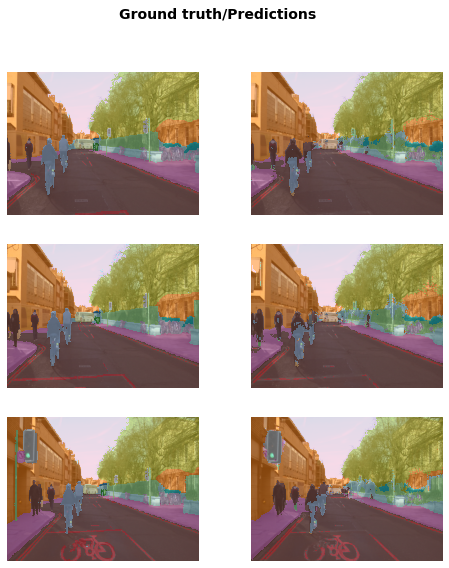

In [32]:
learn.show_results(rows=3, figsize=(8,9))

We have fit a Unet model with resnet weights. Lets unfreeze and finetune the model.

In [33]:
learn.unfreeze()

In [34]:
lrs = slice(lr/400,lr/4)

In [35]:
lrs

slice(7.499999999999999e-07, 7.5e-05, None)

In [36]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.365578,0.314093,0.910659,03:24
1,0.360906,0.312143,0.912084,03:23
2,0.356685,0.319987,0.908608,03:23
3,0.350830,0.318576,0.907681,03:23
4,0.343121,0.317071,0.909344,03:23
5,0.341361,0.324271,0.906726,03:24
6,0.331166,0.304591,0.912192,03:23
7,0.324797,0.300885,0.914428,03:23
8,0.313633,0.281477,0.922020,03:23
9,0.310134,0.284271,0.919619,03:24


We have been able to improve the model from 90% to 91%. Let's save the model and compare the results with a better model. 

In [37]:
learn.save('stage-2');

## Go big

At this stage, we will try a new technique called Progressive Resizing. In this method, we will train an initial model with smaller images for quick training. After this, we will use the same model and train on original images. Since the model has already seen these patterns, the model is going to learn faster and get better.

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
learn.destroy()       # Reset your learner. No need to restart the notebook

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 15559MB of GPU RAM free


In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


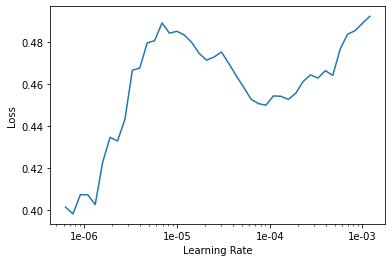

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-4       # Default code was 1e-3 where loss already looks too high

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.396500,0.327355,0.908001,03:39
1,0.376040,0.335624,0.904553,03:35
2,0.357831,0.335885,0.903643,03:36
3,0.356779,0.312660,0.912244,03:36
4,0.358831,0.350069,0.896108,03:35
5,0.353803,0.337646,0.900627,03:35
6,0.339578,0.346632,0.898559,03:35
7,0.318130,0.267764,0.924866,03:35
8,0.292624,0.278461,0.918016,03:35
9,0.255498,0.260542,0.923290,03:36


In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lr=1e-3 
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.250242,0.272980,0.921217,03:43
1,0.275523,0.269041,0.924127,03:42
2,0.266864,0.246420,0.931497,03:42
3,0.273011,0.275986,0.920203,03:42
4,0.249735,0.293681,0.918312,03:42
5,0.234551,0.266510,0.922907,03:42
6,0.214851,0.246940,0.929354,03:42
7,0.207044,0.247676,0.931459,03:42
8,0.193884,0.238134,0.932779,03:42
9,0.189488,0.241677,0.932007,03:42


In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

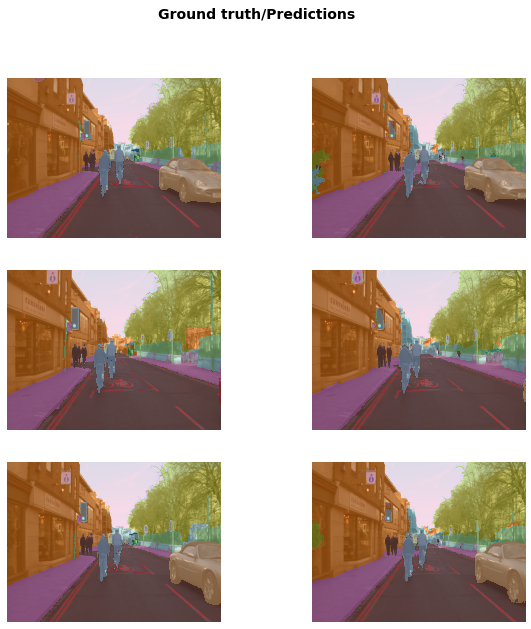

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## Conclusion

After using a progressive resizing we were able to get 93.2% which is a better result than the previous model with half image sizes.

The model can be further improved by using more advanced techniques such as self-attention and mish activation.